In [1]:
import visual_behavior_glm.src.GLM_params as glm_params
import visual_behavior_glm.src.GLM_analysis_tools as gat
import visual_behavior_glm.src.GLM_visualization_tools as gvt
from visual_behavior_glm.src.glm import GLM
import matplotlib.pyplot as plt
import visual_behavior.data_access.loading as loading
import visual_behavior.database as db
import plotly.express as px

import pandas as pd
import numpy as np
import os

import seaborn as sns

import visual_behavior.plotting as vbp

import plotly.express as px
from sklearn.cluster import KMeans
import umap

/home/dougo/Code/AllenSDK/allensdk/brain_observatory/behavior/behavior_ophys_api/behavior_ophys_nwb_api.py:9: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [2]:
%matplotlib notebook
%widescreen

applied a custom magic command to make full use of screen width
will only work if command is defined locally
replace with the following to replicate functionality: 
	from IPython.core.display import display, HTML
	display(HTML("<style>.container { width:100% !important; }</style>")


# Gather/organize data

## load the results summary for a single GLM version from mongo

In [3]:
dropout_summary = gat.retrieve_results(search_dict = {'glm_version': '4_L2_optimize_by_cell'}, results_type='summary')
dropout_summary.sample(10)

,_id,index,dropout,variance_explained,fraction_change_from_full,absolute_change_from_full,cell_specimen_id,ophys_experiment_id,ophys_session_id,behavior_session_id,container_id,project_code,container_workflow_state,experiment_workflow_state,session_name,session_type,equipment_name,date_of_acquisition,isi_experiment_id,specimen_id,sex,age_in_days,full_genotype,reporter_line,driver_line,imaging_depth,targeted_structure,published_at,super_container_id,cre_line,session_tags,failure_tags,exposure_number,model_outputs_available,location,glm_version,entry_time_utc
1097478,5f245f4a654845f21c23f6f3,31,beh_model,0.062846,0.009646,0.000600,962046302,885933191,885401643,885546697,902748564,VisualBehavior,container_qc,passed,20190612_456564_3imagesA,OPHYS_3_images_A,CAM2P.4,2019-06-12 17:35:37.000000,853107722,843387586,F,112.0,Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai94(TITL-G...,['Ai94(TITL-GCaMP6s)'],"['Camk2a-tTA', 'Slc17a7-IRES2-Cre']",175,VISp,NaN,843387586,Slc17a7-IRES2-Cre,NaN,NaN,0,1,Slc17a7_VISp_175,4_L2_optimize_by_cell,2020-07-31 18:13:30.277894
1356507,5f2461d256e3c65600cb2900,27,model_omissions1,-0.027671,0.000109,-0.000003,962644458,806455766,806203732,806296598,803589437,VisualBehavior,container_qc,passed,20190109_425496_1_images_A,OPHYS_1_images_A,CAM2P.4,2019-01-09 21:43:56.000000,781470340,772622653,M,106.0,Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-G...,['Ai93(TITL-GCaMP6f)'],"['Camk2a-tTA', 'Slc17a7-IRES2-Cre']",175,VISp,NaN,772622653,Slc17a7-IRES2-Cre,NaN,NaN,0,1,Slc17a7_VISp_175,4_L2_optimize_by_cell,2020-07-31 18:24:18.793235
1356727,5f2461d356e3c65600cb29dc,23,image6,0.391952,0.000046,0.000018,962643895,806455766,806203732,806296598,803589437,VisualBehavior,container_qc,passed,20190109_425496_1_images_A,OPHYS_1_images_A,CAM2P.4,2019-01-09 21:43:56.000000,781470340,772622653,M,106.0,Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-G...,['Ai93(TITL-GCaMP6f)'],"['Camk2a-tTA', 'Slc17a7-IRES2-Cre']",175,VISp,NaN,772622653,Slc17a7-IRES2-Cre,NaN,NaN,0,1,Slc17a7_VISp_175,4_L2_optimize_by_cell,2020-07-31 18:24:19.282629
594849,5f222dab21d76a4d0f8d0c58,1,intercept,0.016834,0.013248,0.000220,1028793802,906910614,906521029,906658064,1018027647,VisualBehaviorMultiscope,completed,passed,20190715_456915_Ophys4,OPHYS_4_images_B,MESO.1,2019-07-15 11:15:20.640855,852260338,843122504,F,144.0,Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-G...,['Ai93(TITL-GCaMP6f)'],"['Camk2a-tTA', 'Slc17a7-IRES2-Cre']",175,VISp,NaN,843122504,Slc17a7-IRES2-Cre,NaN,NaN,0,1,Slc17a7_VISp_175,4_L2_optimize_by_cell,2020-07-31 18:12:00.216375
1299210,5f246155bc72bede4433c830,19,image2,0.027497,0.006891,0.000188,962643123,809501118,809393834,809427293,803589437,VisualBehavior,container_qc,passed,20190116_425496_6_images_B,OPHYS_6_images_B,CAM2P.4,2019-01-16 21:42:01.000000,781470340,772622653,M,113.0,Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-G...,['Ai93(TITL-GCaMP6f)'],"['Camk2a-tTA', 'Slc17a7-IRES2-Cre']",175,VISp,NaN,772622653,Slc17a7-IRES2-Cre,NaN,NaN,0,1,Slc17a7_VISp_175,4_L2_optimize_by_cell,2020-07-31 18:22:13.138875
308138,5f2228d7a2fcb985550da7d9,27,model_omissions1,0.011125,0.025805,0.000280,1017234958,994082674,993962221,993984422,1018027775,VisualBehaviorMultiscope,completed,passed,20191212_485152_Ophys4_retake,OPHYS_4_images_B,MESO.1,2019-12-12 11:01:10.923267,949762677,935565389,M,154.0,Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-G...,['Ai93(TITL-GCaMP6f)'],"['Camk2a-tTA', 'Slc17a7-IRES2-Cre']",167,VISp,NaN,935565389,Slc17a7-IRES2-Cre,NaN,NaN,1,1,Slc17a7_VISp_167,4_L2_optimize_by_cell,2020-07-31 18:08:29.399054
699507,5f2238a603983b7544a5a4ec,19,image2,0.209753,-0.000233,-0.000049,1007037048,968651957,968445235,968564134,957361481,VisualBehaviorTask1B,container_qc,passed,20191016_479458_6imagesA,OPHYS_6_images_A,CAM2P.4,2019-10-16 20:25:03.000000,928775322,916634005,M,126.0,Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-G...,['Ai93(TITL-GCaMP6f)'],"['Camk2a-tTA', 'Slc17a7-IRES2-Cre']",375,VISp,NaN,916634005,Slc17a7-IRES2-Cre,NaN,NaN,0,1,Slc17a7_VISp_3

In [5]:
dropout_summary_pivoted = gat.build_pivoted_results_summary(results_summary=dropout_summary, cutoff=0.01, value_to_use='fraction_change_from_full')

## get the dominant dropout for each cell in each session

In [6]:
def get_dominant_dropout(row, cols_to_check):
    dominant_dropout = None
    dominant_dropout_value = 0
    for col in cols_to_check:
        if row[col] < dominant_dropout_value:
            dominant_dropout = col
            dominant_dropout_value = row[col]
    return dominant_dropout

cols_to_check = ['all-images','omissions','running','pupil']
dropout_summary_pivoted['dominant_dropout'] = dropout_summary_pivoted.apply(get_dominant_dropout, axis=1, args=[cols_to_check])

In [7]:
dropout_summary_pivoted['dominant_dropout'].unique()

array(['all-images', 'omissions', 'running', 'pupil', None], dtype=object)

## add a `session_id` column with a numeric value for the session_type (to lump together sessions by order, regardless of image set)

In [8]:
def map_session_types(session_type):
    session_id = int(session_type[6:7])
    return session_id
dropout_summary_pivoted['session_id'] = dropout_summary_pivoted['session_type'].map(lambda st:map_session_types(st))

dropout_summary_pivoted

,identifier,Full,all-images,beh_model,change,correct_rejects,false_alarms,hits,image0,image1,image2,image3,image4,image5,image6,image7,image_expectation,intercept,misses,model_bias,model_omissions1,model_task0,model_timing1D,omissions,post_lick_bouts,post_licks,pre_lick_bouts,pre_licks,pupil,rewards,running,time,visual,cell_specimen_id,ophys_experiment_id,ophys_session_id,behavior_session_id,container_id,project_code,container_workflow_state,experiment_workflow_state,session_name,session_type,equipment_name,date_of_acquisition,isi_experiment_id,specimen_id,sex,age_in_days,full_genotype,reporter_line,driver_line,imaging_depth,targeted_structure,published_at,super_container_id,cre_line,session_tags,failure_tags,exposure_number,model_outputs_available,location,glm_version,dominant_dropout,session_id
0,1000743008_1003146172,0.0,-0.140223,-0.001848,0.000581,0.014875,0.008197,0.005280,-0.000634,0.003108,0.002692,0.001819,0.003621,-0.001186,-0.026248,0.002645,0.000947,0.000913,-0.001280,-0.001924,0.000501,-0.000538,0.000135,0.008544,0.007587,-0.005937,0.011424,0.014952,-0.074100,0.010710,-0.020992,-0.001004,-0.228425,1003146172,1000743008,1000580083,1000600602,999191979,VisualBehaviorTask1B,holding,passed,20200116_489056_1imagesB,OPHYS_1_images_B,CAM2P.3,2020-01-16 18:49:41.000000,962029605,951667115,M,165.0,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,['Ai148(TIT2L-GC6f-ICL-tTA2)'],['Sst-IRES-Cre'],275,VISp,NaN,951667115,Sst-IRES-Cre,NaN,NaN,0,1,Sst_VISp_275,4_L2_optimize_by_cell,all-images,1
1,1000743008_1003146180,0.0,-0.155019,0.004636,0.000530,0.020636,0.011811,0.003584,0.002961,0.003979,-0.007203,-0.007210,0.002283,-0.018611,0.002152,0.002657,0.000976,0.000081,0.006030,0.000728,0.001277,0.000856,0.002049,0.020436,0.001011,0.003103,0.031004,0.037226,0.005513,0.032333,-0.002625,0.000434,-0.252412,1003146180,1000743008,1000580083,1000600602,999191979,VisualBehaviorTask1B,holding,passed,20200116_489056_1imagesB,OPHYS_1_images_B,CAM2P.3,2020-01-16 18:49:41.000000,962029605,951667115,M,165.0,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,['Ai148(TIT2L-GC6f-ICL-tTA2)'],['Sst-IRES-Cre'],275,VISp,NaN,951667115,Sst-IRES-Cre,NaN,NaN,0,1,Sst_VISp_275,4_L2_optimize_by_cell,all-images,1
2,1000743008_1003146183,0.0,-0.210215,0.062499,0.000224,0.002435,0.001871,0.001834,0.001881,0.002758,-0.015761,0.000383,0.000302,-0.012279,0.008475,0.001058,-0.001232,-0.002156,0.000572,0.010619,0.029392,-0.001927,0.021750,-0.000316,-0.004966,0.002149,0.003036,0.008150,-0.057209,-0.000740,0.014037,0.004291,-0.319959,1003146183,1000743008,1000580083,1000600602,999191979,VisualBehaviorTask1B,holding,passed,20200116_489056_1imagesB,OPHYS_1_images_B,CAM2P.3,2020-01-16 18:49:41.000000,962029605,951667115,M,165.0,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,['Ai148(TIT2L-GC6f-ICL-tTA2)'],['Sst-IRES-Cre'],275,VISp,NaN,951667115,Sst-IRES-Cre,NaN,NaN,0,1,Sst_VISp_275,4_L2_optimize_by_cell,all-images,1
3,1000743008_1003146186,0.0,-0.368535,0.021722,0.000232,0.002308,0.006869,0.002990,-0.001212,-0.003161,0.000206,-0.049498,0.001615,-0.021775,0.000046,0.002221,-0.003134,0.003374,0.002284,0.014580,0.006673,0.005393,-0.001058,0.002760,-0.001018,0.000574,0.004443,0.004108,0.005936,0.011120,0.001867,0.002495,-0.435852,1003146186,1000743008,1000580083,1000600602,999191979,VisualBehaviorTask1B,holding,passed,20200116_489056_1imagesB,OPHYS_1_images_B,CAM2P.3,2020-01-16 18:49:41.000000,962029605,951667115,M,165.0,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,['Ai148(TIT2L-GC6f-ICL-tTA2)'],['Sst-IRES-Cre'],275,VISp,NaN,951667115,Sst-IRES-Cre,NaN,NaN,0,1,Sst_VISp_275,4_L2_optimize_by_cell,all-images,1
4,1000743008_1003146190,0.0,-0.089674,0.000823,0.000713,0.027508,0.019429,0.006967,0.006088,0.004045,-0.003198,-0.024926,0.003739,0.002454,-0.000550,0.008610,0.001467,0.000038,0.000181,-0.000054,0.001188,0.000657,-0.001699,0.031173,0.010330,0.005812,0.031873,0.030949,-0.019613,0.021468,0.005709,0.000490,-0.184349,1003146190,1000743008,1000580083,1000600602,999191979,VisualBehaviorTa

In [9]:
dropout_summary_pivoted.columns

Index(['identifier', 'Full', 'all-images', 'beh_model', 'change',
       'correct_rejects', 'false_alarms', 'hits', 'image0', 'image1', 'image2',
       'image3', 'image4', 'image5', 'image6', 'image7', 'image_expectation',
       'intercept', 'misses', 'model_bias', 'model_omissions1', 'model_task0',
       'model_timing1D', 'omissions', 'post_lick_bouts', 'post_licks',
       'pre_lick_bouts', 'pre_licks', 'pupil', 'rewards', 'running', 'time',
       'visual', 'cell_specimen_id', 'ophys_experiment_id', 'ophys_session_id',
       'behavior_session_id', 'container_id', 'project_code',
       'container_workflow_state', 'experiment_workflow_state', 'session_name',
       'session_type', 'equipment_name', 'date_of_acquisition',
       'isi_experiment_id', 'specimen_id', 'sex', 'age_in_days',
       'full_genotype', 'reporter_line', 'driver_line', 'imaging_depth',
       'targeted_structure', 'published_at', 'super_container_id', 'cre_line',
       'session_tags', 'failure_tags', 'exposu

In [10]:
dropout_summary_pivoted.equipment_name.unique()

array(['CAM2P.3', 'CAM2P.4', 'CAM2P.5', 'MESO.1'], dtype=object)

## Turn some categorical columns into numerical columns

In [11]:
def make_categorical(df, column):
    df['{}_categorical'.format(column)] = pd.Categorical(df[column], ordered=True).codes

for column in ['cre_line','equipment_name','targeted_structure','session_id','dominant_dropout']:
    make_categorical(dropout_summary_pivoted, column)
    
dropout_summary_pivoted

,identifier,Full,all-images,beh_model,change,correct_rejects,false_alarms,hits,image0,image1,image2,image3,image4,image5,image6,image7,image_expectation,intercept,misses,model_bias,model_omissions1,model_task0,model_timing1D,omissions,post_lick_bouts,post_licks,pre_lick_bouts,pre_licks,pupil,rewards,running,time,visual,cell_specimen_id,ophys_experiment_id,ophys_session_id,behavior_session_id,container_id,project_code,container_workflow_state,experiment_workflow_state,session_name,session_type,equipment_name,date_of_acquisition,isi_experiment_id,specimen_id,sex,age_in_days,full_genotype,reporter_line,driver_line,imaging_depth,targeted_structure,published_at,super_container_id,cre_line,session_tags,failure_tags,exposure_number,model_outputs_available,location,glm_version,dominant_dropout,session_id,cre_line_categorical,equipment_name_categorical,targeted_structure_categorical,session_id_categorical,dominant_dropout_categorical
0,1000743008_1003146172,0.0,-0.140223,-0.001848,0.000581,0.014875,0.008197,0.005280,-0.000634,0.003108,0.002692,0.001819,0.003621,-0.001186,-0.026248,0.002645,0.000947,0.000913,-0.001280,-0.001924,0.000501,-0.000538,0.000135,0.008544,0.007587,-0.005937,0.011424,0.014952,-0.074100,0.010710,-0.020992,-0.001004,-0.228425,1003146172,1000743008,1000580083,1000600602,999191979,VisualBehaviorTask1B,holding,passed,20200116_489056_1imagesB,OPHYS_1_images_B,CAM2P.3,2020-01-16 18:49:41.000000,962029605,951667115,M,165.0,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,['Ai148(TIT2L-GC6f-ICL-tTA2)'],['Sst-IRES-Cre'],275,VISp,NaN,951667115,Sst-IRES-Cre,NaN,NaN,0,1,Sst_VISp_275,4_L2_optimize_by_cell,all-images,1,1,0,1,0,0
1,1000743008_1003146180,0.0,-0.155019,0.004636,0.000530,0.020636,0.011811,0.003584,0.002961,0.003979,-0.007203,-0.007210,0.002283,-0.018611,0.002152,0.002657,0.000976,0.000081,0.006030,0.000728,0.001277,0.000856,0.002049,0.020436,0.001011,0.003103,0.031004,0.037226,0.005513,0.032333,-0.002625,0.000434,-0.252412,1003146180,1000743008,1000580083,1000600602,999191979,VisualBehaviorTask1B,holding,passed,20200116_489056_1imagesB,OPHYS_1_images_B,CAM2P.3,2020-01-16 18:49:41.000000,962029605,951667115,M,165.0,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,['Ai148(TIT2L-GC6f-ICL-tTA2)'],['Sst-IRES-Cre'],275,VISp,NaN,951667115,Sst-IRES-Cre,NaN,NaN,0,1,Sst_VISp_275,4_L2_optimize_by_cell,all-images,1,1,0,1,0,0
2,1000743008_1003146183,0.0,-0.210215,0.062499,0.000224,0.002435,0.001871,0.001834,0.001881,0.002758,-0.015761,0.000383,0.000302,-0.012279,0.008475,0.001058,-0.001232,-0.002156,0.000572,0.010619,0.029392,-0.001927,0.021750,-0.000316,-0.004966,0.002149,0.003036,0.008150,-0.057209,-0.000740,0.014037,0.004291,-0.319959,1003146183,1000743008,1000580083,1000600602,999191979,VisualBehaviorTask1B,holding,passed,20200116_489056_1imagesB,OPHYS_1_images_B,CAM2P.3,2020-01-16 18:49:41.000000,962029605,951667115,M,165.0,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,['Ai148(TIT2L-GC6f-ICL-tTA2)'],['Sst-IRES-Cre'],275,VISp,NaN,951667115,Sst-IRES-Cre,NaN,NaN,0,1,Sst_VISp_275,4_L2_optimize_by_cell,all-images,1,1,0,1,0,0
3,1000743008_1003146186,0.0,-0.368535,0.021722,0.000232,0.002308,0.006869,0.002990,-0.001212,-0.003161,0.000206,-0.049498,0.001615,-0.021775,0.000046,0.002221,-0.003134,0.003374,0.002284,0.014580,0.006673,0.005393,-0.001058,0.002760,-0.001018,0.000574,0.004443,0.004108,0.005936,0.011120,0.001867,0.002495,-0.435852,1003146186,1000743008,1000580083,1000600602,999191979,VisualBehaviorTask1B,holding,passed,20200116_489056_1imagesB,OPHYS_1_images_B,CAM2P.3,2020-01-16 18:49:41.000000,962029605,951667115,M,165.0,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,['Ai148(TIT2L-GC6f-ICL-tTA2)'],['Sst-IRES-Cre'],275,VISp,NaN,951667115,Sst-IRES-Cre,NaN,NaN,0,1,Sst_VISp_275,4_L2_optimize_by_cell,all-images,1,1,0,1,0,0
4,1000743008_1003146190,0.0,-0.089674,0.000823,0.000713,0.027508,0.019429,0.006967,0.006088,0.004045,-0.003198,-0.024926,0.003739,0.002454,-0.000550,0.008610,0.001467,0.000038,0.000181,-0.000054,0.001188,0.000657,-

## category == -1 represents None, set it to NaN

In [12]:
np.sort(dropout_summary_pivoted['dominant_dropout_categorical'].unique())

array([-1,  0,  1,  2,  3], dtype=int8)

In [13]:
dropout_summary_pivoted.loc[dropout_summary_pivoted.query('dominant_dropout_categorical == -1').index,'dominant_dropout_categorical'] = np.nan

## merge in some columns from the original response_summary

In [14]:
dominant_dropout_matrix = (
    dropout_summary_pivoted
    .drop_duplicates(['cell_specimen_id','session_id'])
    .pivot(index='cell_specimen_id',columns='session_id',values='dominant_dropout_categorical')
    .rename(columns={k:'session_{}'.format(k) for k in dropout_summary_pivoted['session_id'].unique()})
)

cols_to_merge = [
    'cell_specimen_id',
    'cre_line',
    'cre_line_categorical',
    'imaging_depth',
    'targeted_structure',
    'targeted_structure_categorical',
    'equipment_name'
]
dominant_dropout_matrix = dominant_dropout_matrix.merge(
    dropout_summary_pivoted[cols_to_merge],
    left_on='cell_specimen_id',
    right_on='cell_specimen_id',
    how='left',
).set_index('cell_specimen_id')
dominant_dropout_matrix

,session_1,session_3,session_4,session_6,cre_line,cre_line_categorical,imaging_depth,targeted_structure,targeted_structure_categorical,equipment_name
cell_specimen_id,,,,,,,,,,
817101743,NaN,NaN,NaN,1.0,Vip-IRES-Cre,2,175,VISp,1,CAM2P.4
817101771,0.0,0.0,NaN,3.0,Vip-IRES-Cre,2,175,VISp,1,CAM2P.4
817101771,0.0,0.0,NaN,3.0,Vip-IRES-Cre,2,175,VISp,1,CAM2P.4
817101771,0.0,0.0,NaN,3.0,Vip-IRES-Cre,2,175,VISp,1,CAM2P.4
817101837,0.0,1.0,NaN,3.0,Vip-IRES-Cre,2,175,VISp,1,CAM2P.4
...,...,...,...,...,...,...,...,...,...,...
1028894295,0.0,NaN,NaN,NaN,Vip-IRES-Cre,2,81,VISp,1,MESO.1
1028894317,2.0,NaN,NaN,NaN,Vip-IRES-Cre,2,81,VISp,1,MESO.1
1028894343,0.0,NaN,NaN,NaN,Vip-IRES-Cre,2,81,VISp,1,MESO.1


## define plot/heatmap parameters

In [16]:
# make sure there's a heatmap definition for every column, otherwise the column will plot without a heatmap!
cols_to_plot = [
    'session_1',
    'session_3',
    'session_4',
    'session_6',
    'cre_line_categorical',
    'targeted_structure_categorical',
    'imaging_depth',
]
heatmap_defs = [
    {
        'columns':['session_{}'.format(i) for i in [1,3,4,6]],
        'cbar_label':'dominant_dropout',
        'cbar_ticks':np.arange(0.5,4.5),
        'cbar_ticklabels':np.sort([c for c in dropout_summary_pivoted['dominant_dropout'].unique() if pd.notnull(c)]),
        'vmin':0,
        'vmax':4,
        'cmap':sns.color_palette("Dark2", 4),
    },
    {
        'columns':['cre_line_categorical'],
        'cbar_label':'cre_line',
        'cbar_ticks':[0,1,2],
        'cbar_ticklabels':np.sort(np.unique(dropout_summary_pivoted['cre_line'])),
        'vmin':-0.5,
        'vmax':2.5,
        'cmap':sns.color_palette("hls", 3),
    },
    {
        'columns':['targeted_structure_categorical'],
        'cbar_label':'targeted structure',
        'cbar_ticks':np.arange(len(dropout_summary_pivoted['targeted_structure_categorical'].unique())),
        'cbar_ticklabels':np.sort(np.unique(dropout_summary_pivoted['targeted_structure'])),
        'vmin':-0.5,
        'vmax':len(dropout_summary_pivoted['targeted_structure'].unique())-0.5,
        'cmap':sns.color_palette("hls", len(dropout_summary_pivoted['targeted_structure'].unique())),
    },
    {
        'columns':['imaging_depth'],
        'cbar_label':'imaging_depth',
        'cbar_ticks':[0,100,200,300,400],
        'vmin':0,
        'vmax':400,
        'cmap':'magma',
    },
]

# plots

## Everything, sorted by cre-line, dropouts in sessions, depth

<IPython.core.display.Javascript object>


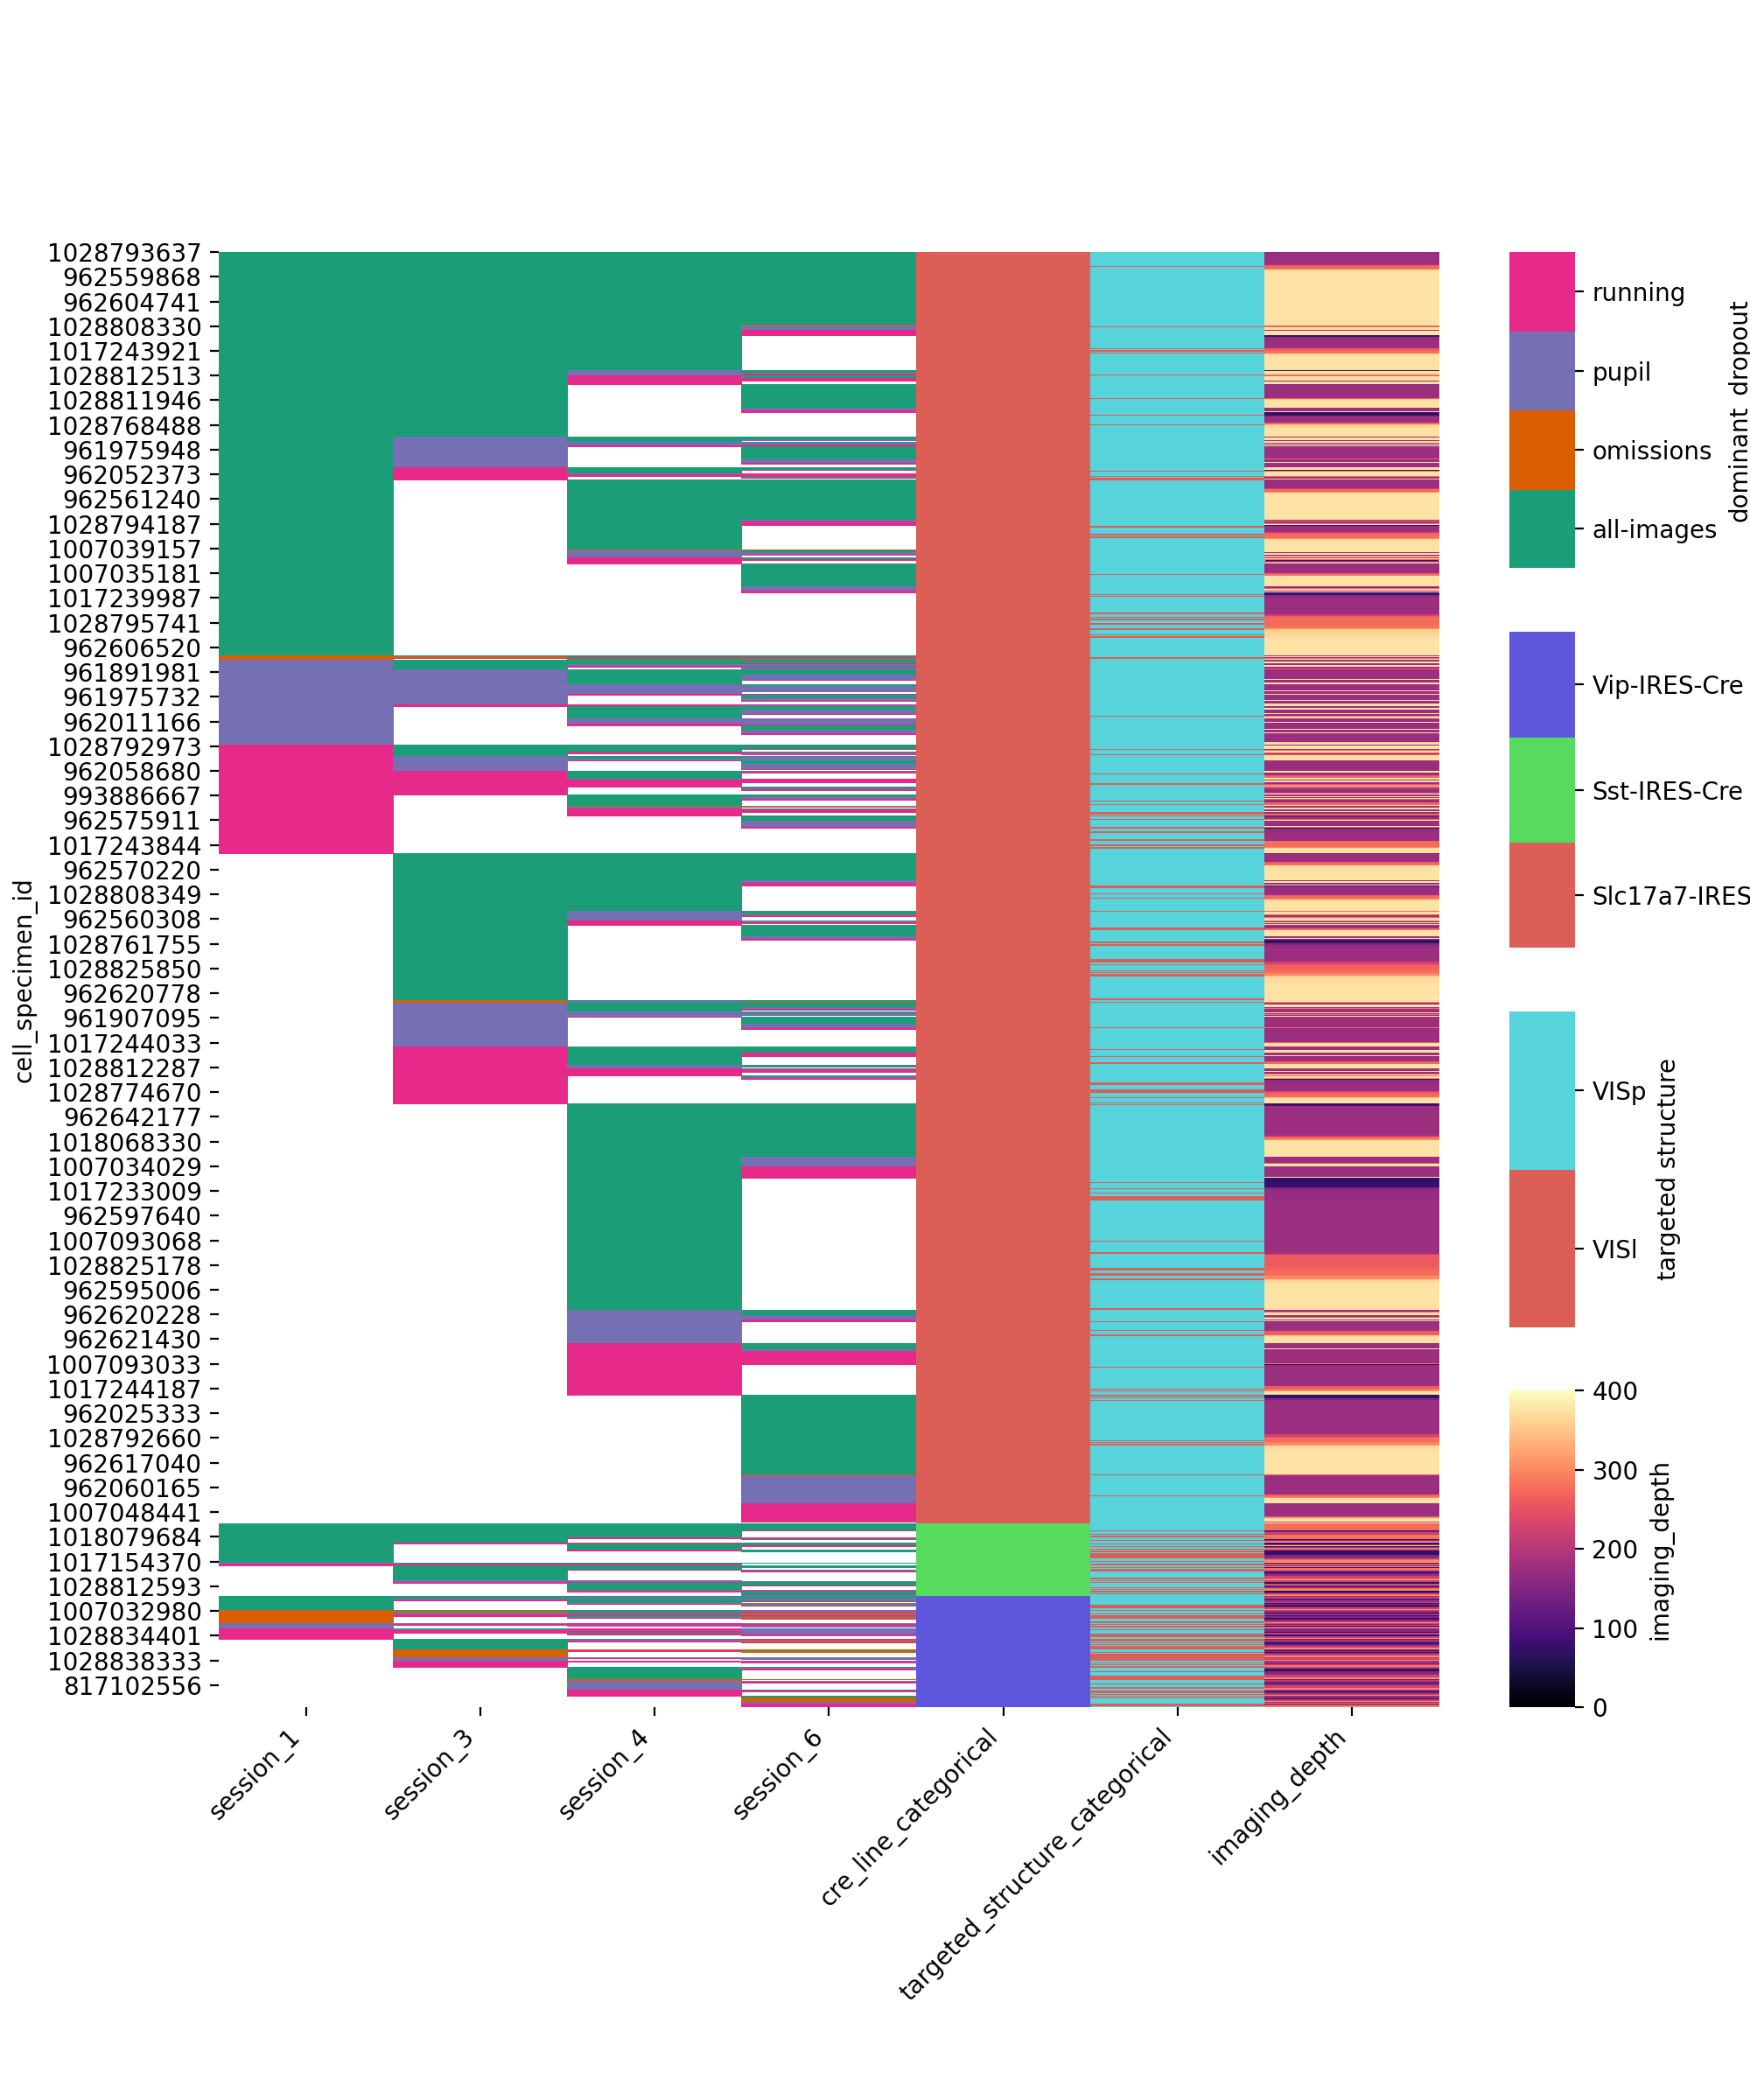

In [17]:
sort_by = [
    'cre_line_categorical',
    'session_1',
    'session_3',
    'session_4',
    'session_6',
    'imaging_depth'
]
data_to_plot = dominant_dropout_matrix[cols_to_plot].sort_values(by=sort_by)
fig, axes = vbp.make_multi_cmap_heatmap(
    data_to_plot, 
    heatmap_defs, 
    figsize=(10,12), 
    top_buffer=0, 
    bottom_buffer=0.1, 
    n_cbar_rows=4, 
    heatmap_div=0.9, 
)

## only cells that are matched across all sessions, same sorting as above

<IPython.core.display.Javascript object>


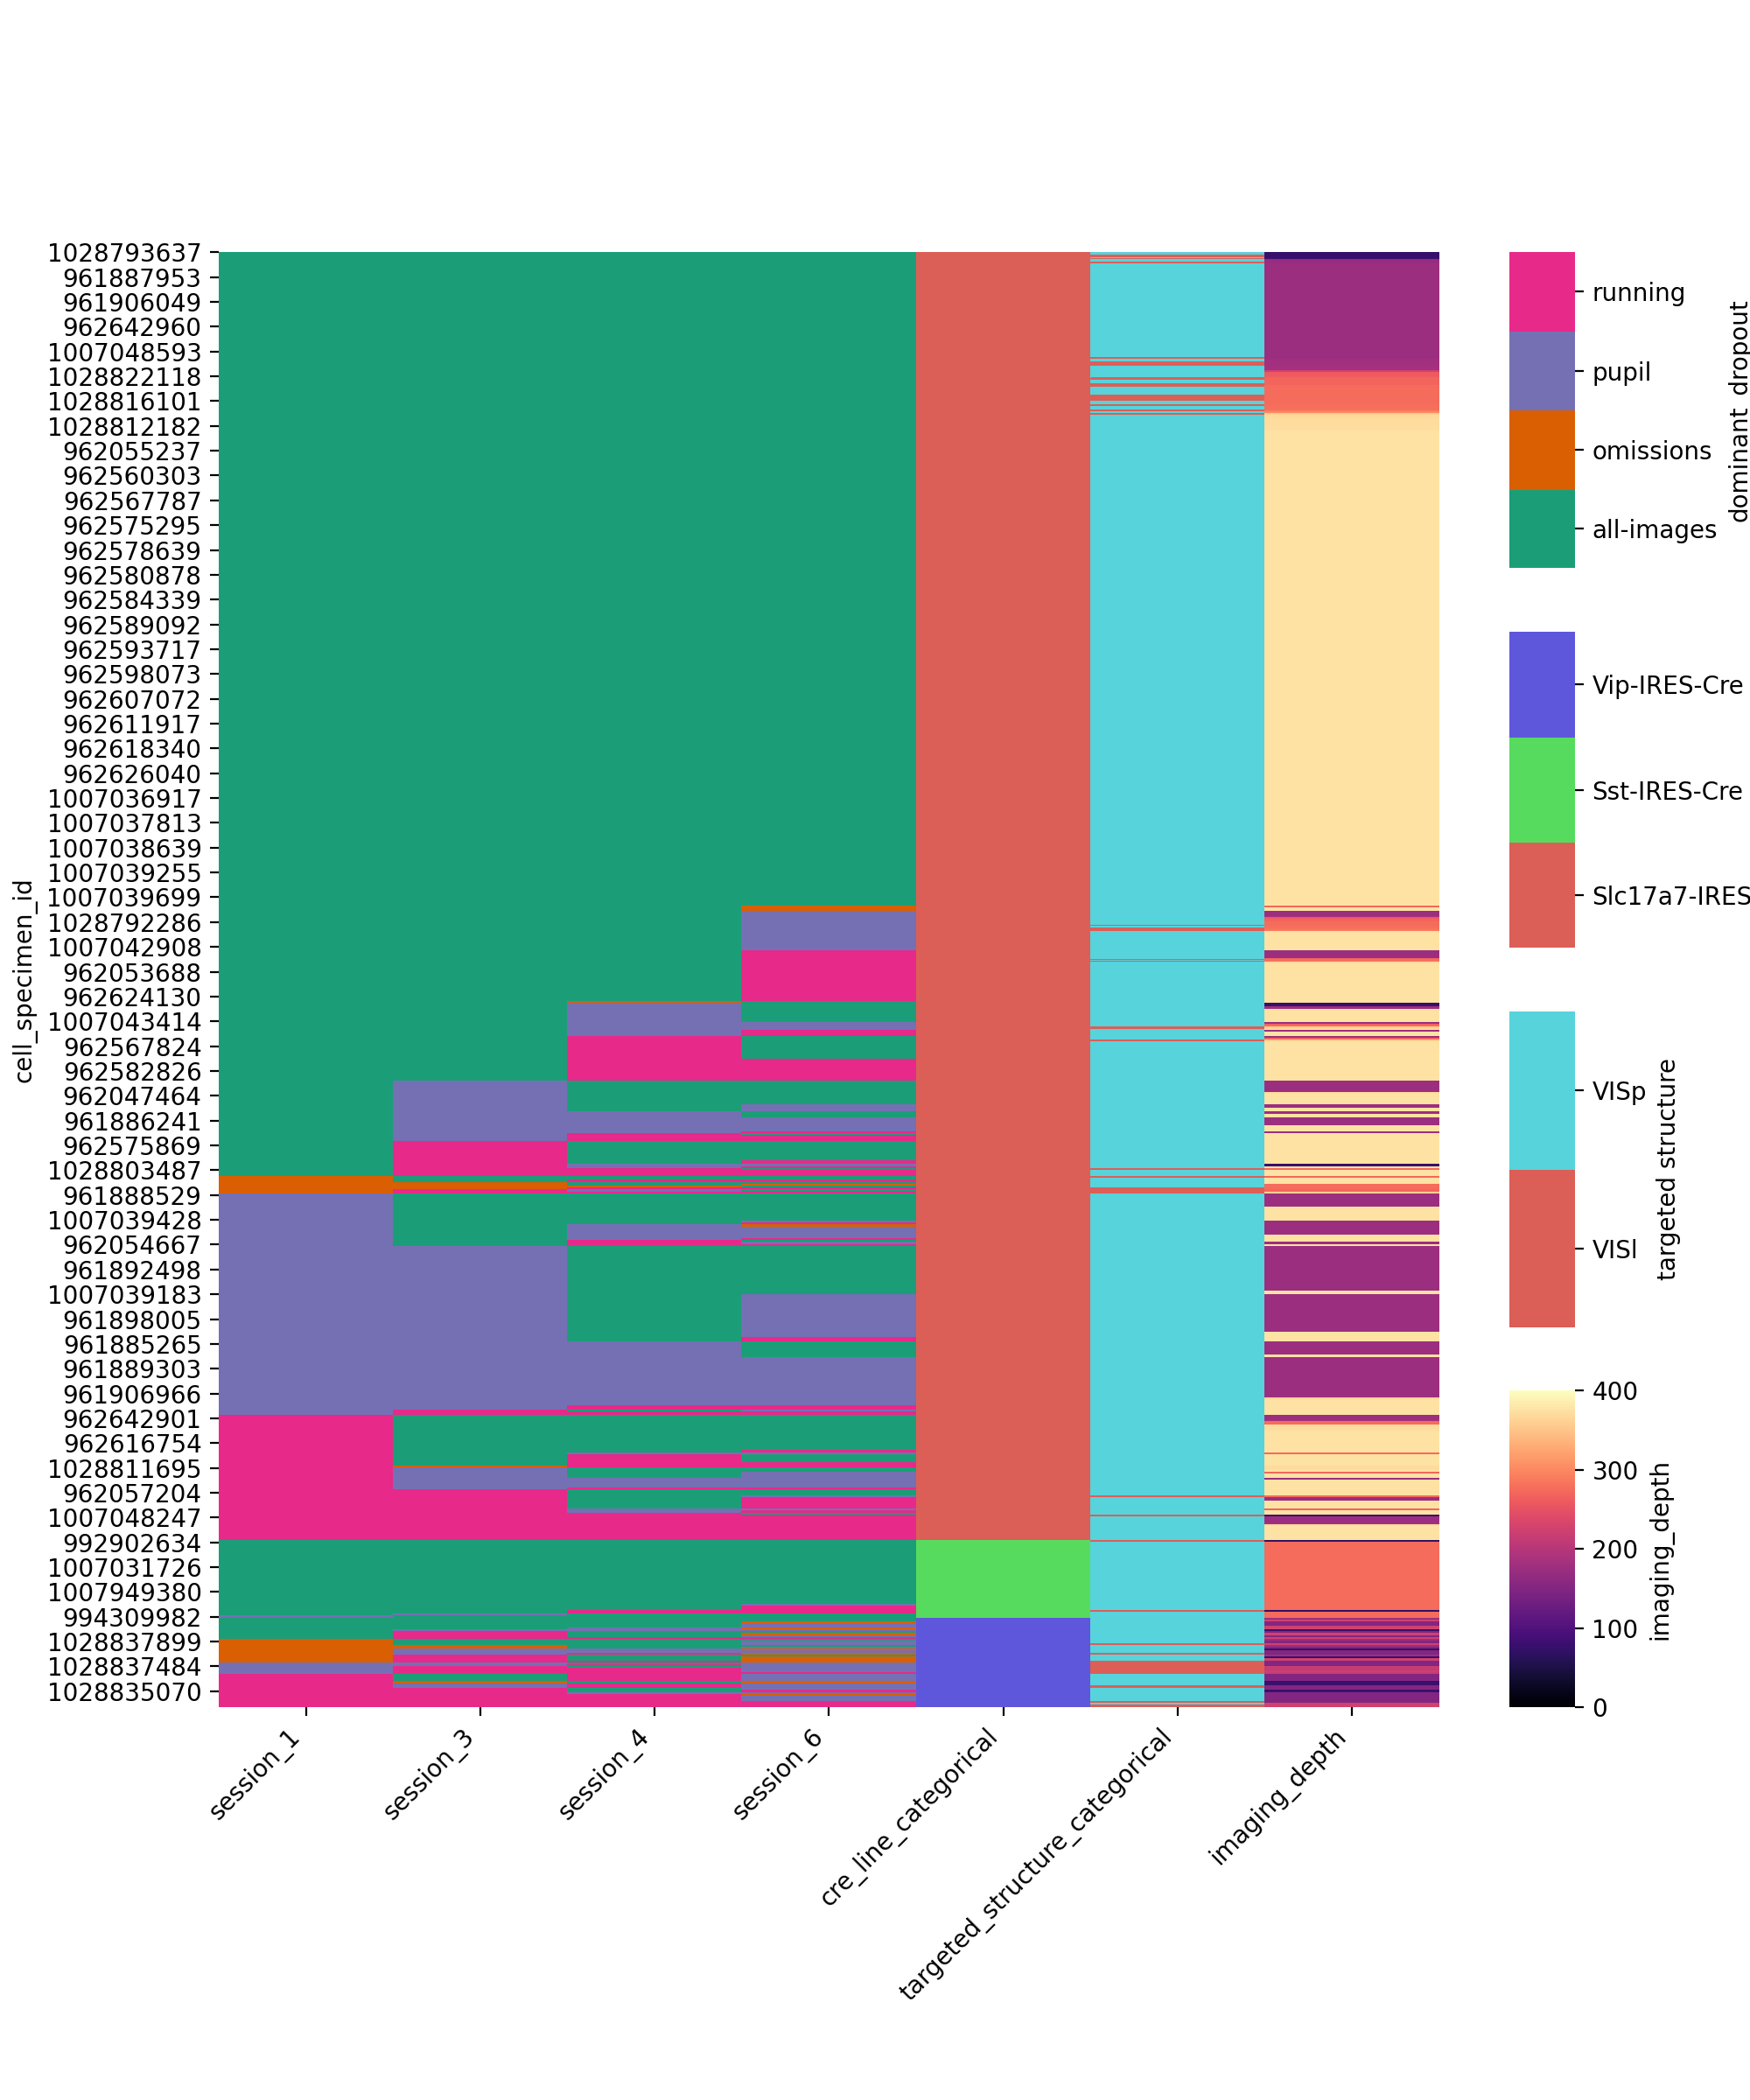

In [18]:
sort_by = [
    'cre_line_categorical',
    'session_1',
    'session_3',
    'session_4',
    'session_6',
    'imaging_depth'
]
data_to_plot = dominant_dropout_matrix[cols_to_plot].sort_values(by=sort_by).dropna()
fig, axes = vbp.make_multi_cmap_heatmap(
    data_to_plot, 
    heatmap_defs, 
    figsize=(10,12), 
    top_buffer=0, 
    bottom_buffer=0.1, 
    n_cbar_rows=4, 
    heatmap_div=0.9, 
)

## exclude mesoscope sessions, only include cells matched across sessions

<IPython.core.display.Javascript object>


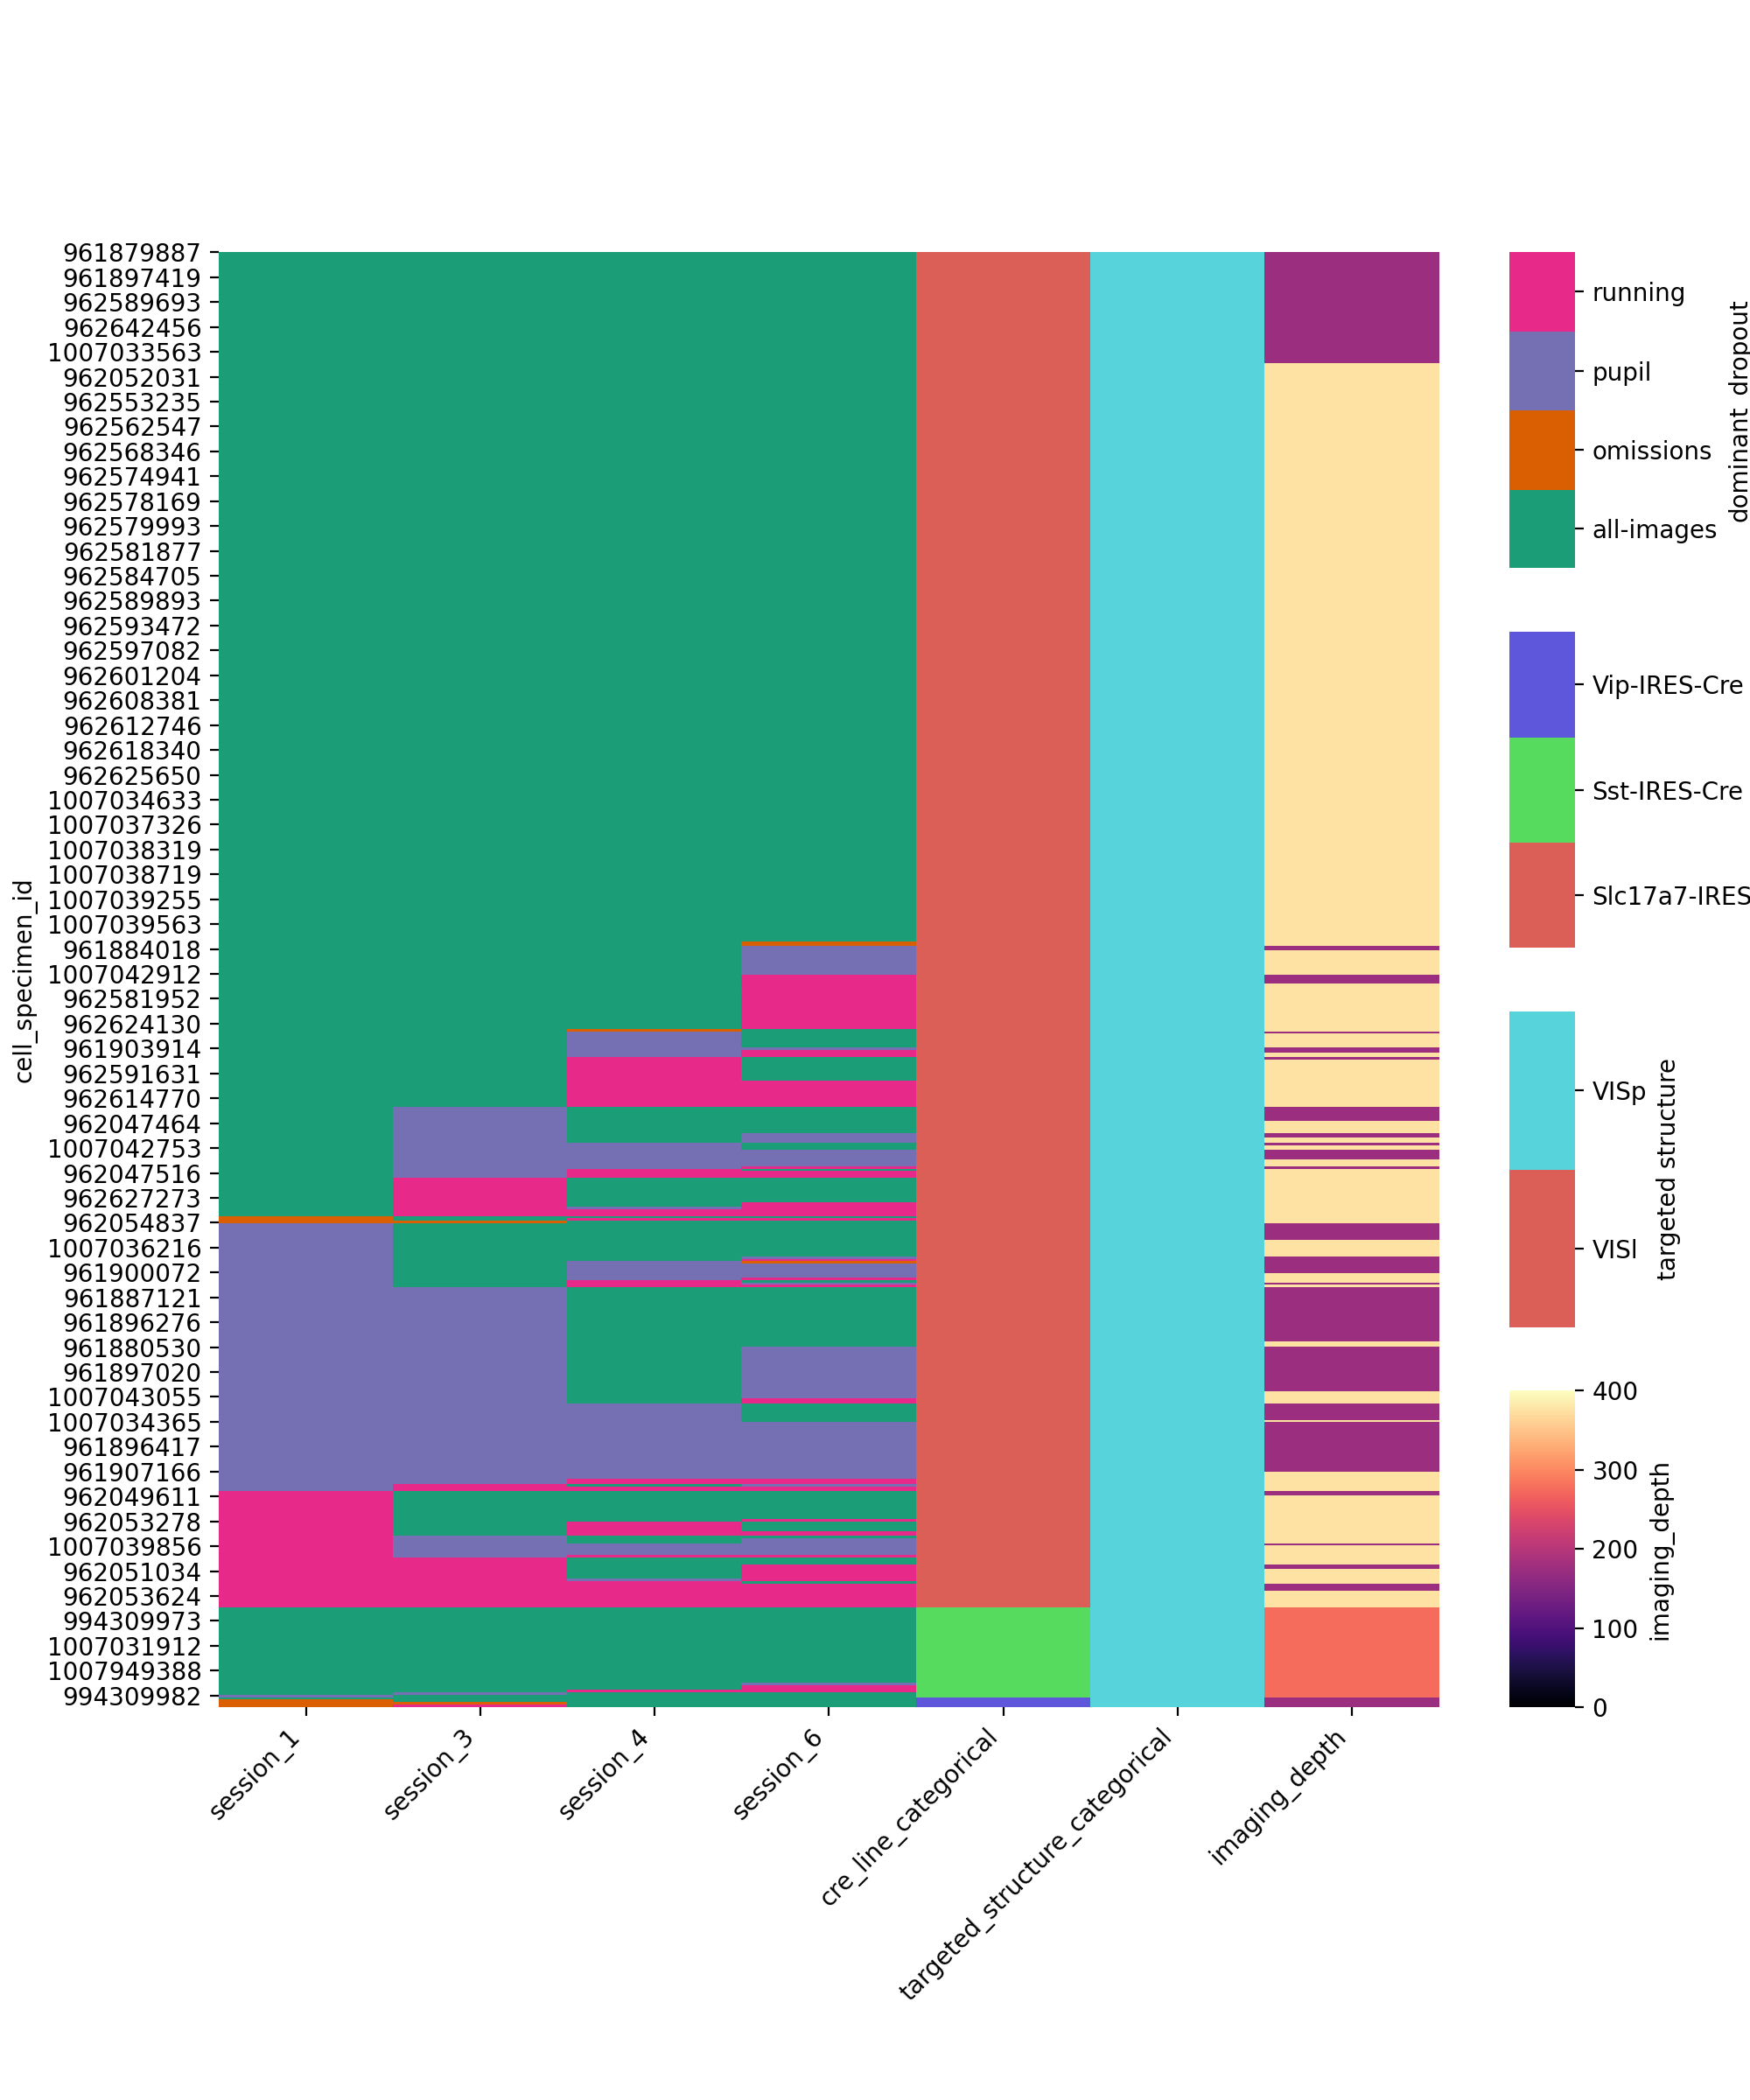

In [19]:
sort_by = [
    'cre_line_categorical',
    'imaging_depth'
]
data_to_plot = (
    dominant_dropout_matrix.query('equipment_name != "MESO.1"')[cols_to_plot]
    .sort_values(by=sort_by)
    .dropna()
)
fig, axes = vbp.make_multi_cmap_heatmap(
    data_to_plot, 
    heatmap_defs, 
    figsize=(10,12), 
    top_buffer=0, 
    bottom_buffer=0.1, 
    n_cbar_rows=4, 
    heatmap_div=0.9, 
)

## sort only by cre-line and depth (still excluding mesoscope)

<IPython.core.display.Javascript object>


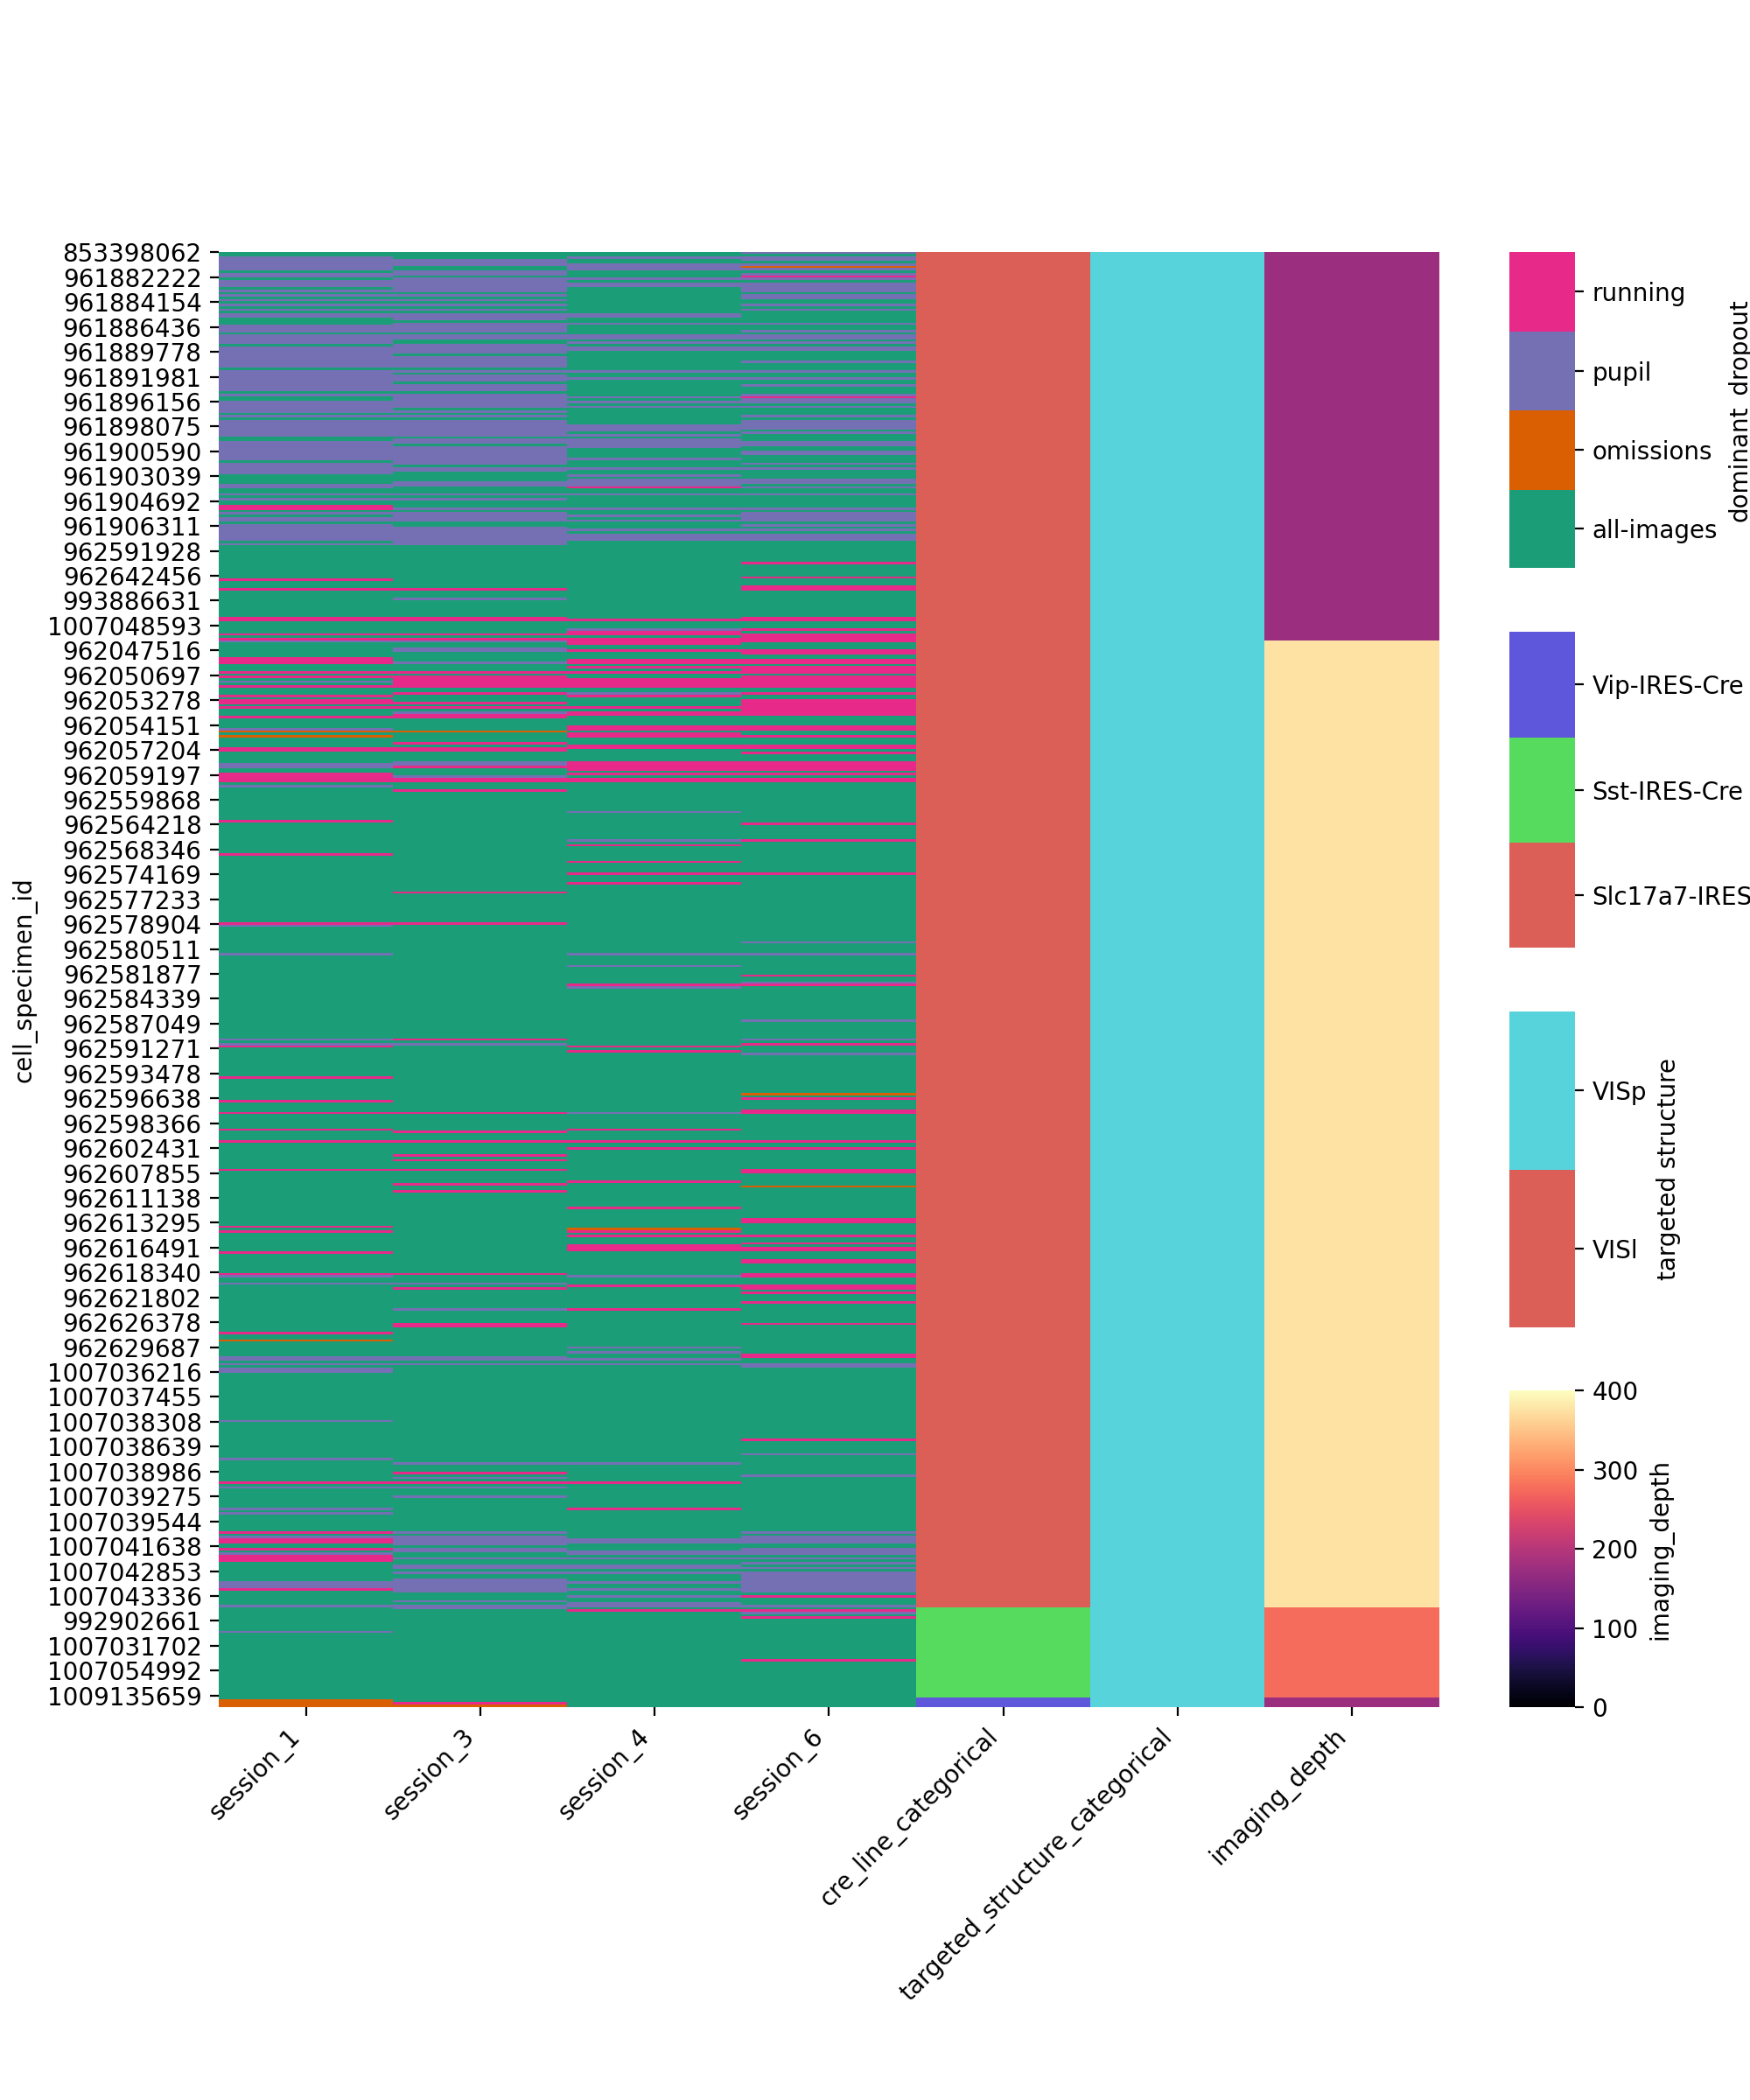

In [24]:
sort_by = [
    'cre_line_categorical',
    'imaging_depth',
]
data_to_plot = (
    dominant_dropout_matrix.query('equipment_name != "MESO.1"')[cols_to_plot]
    .sort_values(by=sort_by)
    .dropna()
)
fig, axes = vbp.make_multi_cmap_heatmap(
    data_to_plot, 
    heatmap_defs, 
    figsize=(10,12), 
    top_buffer=0, 
    bottom_buffer=0.1, 
    n_cbar_rows=4, 
    heatmap_div=0.9, 
)